<a href="https://colab.research.google.com/github/amomen1218/python-for-remote-sensing/blob/main/buffer_neighbors_vector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from io import StringIO

data = """
ID,X,Y
1,  -87.55,  41.85
1,  -87.55,  41.70

2,  -87.599,  41.908
2,  -87.598,  41.708
2,  -87.643,  41.675
"""
# use StringIO to read in text chunk
df = pd.read_table(StringIO(data), sep=',')

#zip the coordinates into a point object and convert to a GeoData Frame
points = [Point(xy) for xy in zip(df.X, df.Y)]
points = gpd.GeoDataFrame(df, geometry=points, crs = 'EPSG:4326')
# create line for each ID
lines = points.groupby(['ID'])['geometry'].apply(lambda x:  LineString(x.tolist()))
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326")
lines.reset_index(inplace=True)


<Axes: >

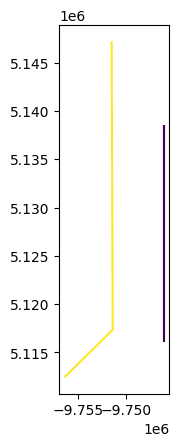

In [42]:
# plot county outline and add wells to axis (ax)
lines.plot(column='ID')

In [36]:
# plot county outline and add wells to axis (ax)
lines = lines.to_crs(3857)
# check the linear unit name in `unit_name`.
print(lines.crs.axis_info)

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]


0    POLYGON ((-9747021.419 5116146.295, -9747021.4...
1    POLYGON ((-9750364.761 5117342.85, -9750369.36...
dtype: geometry


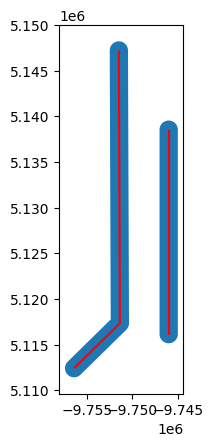

In [37]:
buf = lines.buffer(distance = 1000)
bp = buf.plot()
lines.plot(ax=bp, color='red')
print(buf)

In [38]:
line_buffer = lines.copy()
line_buffer['geometry'] = buf
print(line_buffer)

   ID                                           geometry
0   1  POLYGON ((-9747021.419 5116146.295, -9747021.4...
1   2  POLYGON ((-9750364.761 5117342.85, -9750369.36...


<Axes: >

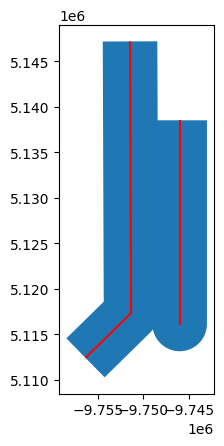

In [39]:
buf = lines.buffer(distance = 3000, cap_style = 2)
bp = buf.plot()
lines.plot(ax=bp, color='red')

<Axes: >

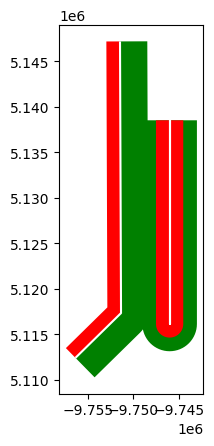

In [40]:
buf_right = lines.buffer(distance = 3000, single_sided = True)
bp = buf_right.plot(color='green')

buf_left = lines.buffer(distance = -1500, single_sided = True)
buf_left.plot(ax=bp, color='red')
lines.plot(ax=bp, color='white')

In [41]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)


In [15]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


In [16]:
nearest_geoms = nearest_points(orig, destinations)
original_point, nearest_destination = nearest_geoms
print(nearest_geoms)
print('Coordinates of original point:',original_point)
print('Coordinates of closest destination point:',nearest_destination)

(<POINT (1 1.67)>, <POINT (0 1.45)>)
Coordinates of original point: POINT (1 1.67)
Coordinates of closest destination point: POINT (0 1.45)


In [17]:
from shapely.ops import nearest_points

def _nearest(row, df1, df2, geom1='geometry', geom2='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column."""

    # create object usable by Shapely
    geom_union = df2.unary_union

    # Find the geometry that is closest
    nearest = df2[geom2] == nearest_points(row[geom1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    if df2_column is None:
        value = df2[nearest].index[0]
    else:
        value = df2[nearest][df2_column].values[0]
    return value

def nearest(df1, df2, geom1_col='geometry', geom2_col='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column.
    :param df1: Origin points
    :type df1: geopandas.GeoDataFrame
    :param df2: Destination points
    :type df2: geopandas.GeoDataFrame
    :param geom1_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom1_col: str, optional
    :param geom2_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom2_col: str, optional
    :param df2_column: column name to return from df2, defaults to None
    :type df2_column: str, optional
    :return: df1 with nearest neighbor index or df2_column appended
    :rtype: geopandas.GeoDataFrame
    """
    df1['nearest_id'] = df1.apply(_nearest,  df1=df1, df2=df2,
                                  geom1=geom1_col, geom2=geom2_col,
                                  df2_column=df2_column, axis=1)
    return df1

In [18]:
# generate origin and destination points as geodataframe
orig = {'name': ['Origin_1','Origin_2'],
     'geometry': [Point(-77.3,38.94),Point(-77.41,39.93)]}
orig = gpd.GeoDataFrame(orig, crs="EPSG:4326")
print(orig)

dest = {'name': ['Baltimore','Washington', 'Fredrick'],
     'geometry': [ Point(-76.61,39.29,), Point(-77.04,38.91), Point(-77.40,39.41)]}
dest = gpd.GeoDataFrame(dest, crs="EPSG:4326")
print(dest)

       name              geometry
0  Origin_1   POINT (-77.3 38.94)
1  Origin_2  POINT (-77.41 39.93)
         name              geometry
0   Baltimore  POINT (-76.61 39.29)
1  Washington  POINT (-77.04 38.91)
2    Fredrick   POINT (-77.4 39.41)


In [19]:
near = nearest(df1=orig, df2=dest, df2_column='name')
near.head()

<ipython-input-17-b2961d5163ab>:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = df2.unary_union
<ipython-input-17-b2961d5163ab>:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom_union = df2.unary_union


,name,geometry,nearest_id
0,Origin_1,POINT (-77.3 38.94),Washington
1,Origin_2,POINT (-77.41 39.93),Fredrick
